# Voronoi Graphs

In [62]:
# Make the relevant imports including Voronoi methods
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline 

In [63]:
plt.rcParams["figure.figsize"] = [12, 12]
#To reset the global figure size back to default for subsequent plots:
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

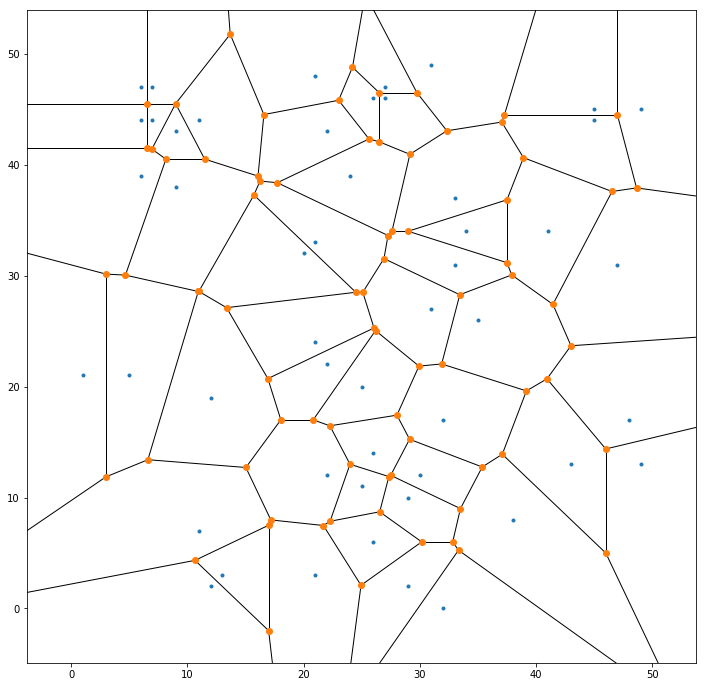

In [64]:
# Recreate the figure above for a new set of random points
points = np.random.randint(50, size=(50, 2))
graph = Voronoi(points)
voronoi_plot_2d(graph)
plt.show()

In [65]:
# Read in the obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)

In [66]:
# If you want to use the prebuilt bresenham method
# Import the Bresenham package
from bresenham import bresenham

In [67]:
def bresenham_udct(p1, p2):
    """
    Note this solution requires `x1` < `x2` and `y1` < `y2`.
    """
    x1, y1 = p1
    x2, y2 = p2
    cells = []
    
    # Here's a quick explanation in math terms of our approach
    # First, set dx = x2 - x1 and dy = y2 - y1
    dx, dy = x2 - x1, y2 - y1
    # Then define a new quantity: d = x dy - y dx.
    # and set d = 0 initially
    d = 0
    # The condition we care about is whether 
    # (x + 1) * m < y + 1 or moving things around a bit: 
    # (x + 1) dy / dx < y + 1 
    # which implies: x dy - y dx < dx - dy
    # or in other words: d < dx - dy is our new condition
    
    # Initialize i, j indices
    i = x1
    j = y1
    
    while i < x2 and j < y2:
        cells.append([int(i), int(j)])
        if d < dx - dy:
            d += dy
            i += 1
        elif d == dx - dy:
            # uncomment these two lines for conservative approach
            cells.append([int(i+1), int(j)])
            cells.append([int(i), int(j+1)])
            d += dy
            i += 1  
            d -= dx
            j += 1
        else:
            d -= dx
            j += 1

    return np.array(cells)

In [81]:
# Here you'll modify the `create_grid()` method from a previous exercise
# In this new function you'll record obstacle centres and
# create a Voronoi graph around those points
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])
    
    # Define a list to hold Voronoi points
    points = []
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]

        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(north - d_north - safety_distance - north_min_center),
                int(north + d_north + safety_distance - north_min_center),
                int(east - d_east - safety_distance - east_min_center),
                int(east + d_east + safety_distance - east_min_center),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1
            
            # add center of obstacles to points list
            points.append([north - north_min, east - east_min])

    # TODO: create a voronoi graph based on
    # location of obstacle centres
    # Extract the Voronoi diagram
    graph = Voronoi(points)

    # TODO: check each edge from graph.ridge_vertices for collision
   # Step through each pair of points that define a ridge like this
    edges = []  # Empty list to contain valid edges
    for v in graph.ridge_vertices:
        p1 = graph.vertices[v[0]]
        p2 = graph.vertices[v[1]]
        if (p1[0]<0 or p1[1]<0 or p2[0]<0 or p2[1]<0 or
            p1[0] > east_size or p1[1] > north_size or 
            p2[0] > east_size or p2[1] >north_size):
            print(" *** Warning! *** \n\t One or more points ({}) , ({}) \n\t out of the range east[0:{}] north[0:{}]\n***".format(p1,p2,east_size,north_size) )
            continue
        


        # Test each pair p1 and p2 for collision using Bresenham
        # (need to convert to integer if using prebuilt Python package)
        # If the edge does not hit an obstacle
        # add it to the list
        def in_collision(grid , p1, p2):
            # bresenham(x0, y0, x1, y1)
            line_int_coordinates = bresenham(int(p1[0]),int(p1[1]), int(p2[0]),int(p2[1]))
            collision_points = [not(grid[p[0],p[1]] == 0) for p in line_int_coordinates]
            #print("collision_points",collision_points)
            #print("any(collision_points)",any(collision_points))
            any_collision = any(collision_points)
            return any_collision
            
        if not in_collision(grid , p1, p2):
            edges.append((p1, p2))
    

    return grid, edges

In [82]:
# Define a flying altitude (feel free to change this)
drone_altitude = 5
safety_distance = 3
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print('Found %5d edges' % len(edges))

 *** Warning! *** 
	 One or more points ([800.7611 890.7685]) , ([840.7611 930.7685]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([820.7611 890.7685]) , ([840.7611 930.7685]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([1019.33252857  839.33992857]) , ([910.7611 730.7685]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([1019.33252857  839.33992857]) , ([905.17286471 797.82732353]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([4.25761120e+02 3.50091377e+06]) , ([420.76110929 908.26847661]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([4.25761120e+02 3.50091377e+06]) , ([460.76115 910.7685 ]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([1050.7611   10.7685]) , ([890.7611  10.7685]) 
	 out of the range east[0:921] north[0:

 *** Warning! *** 
	 One or more points ([550.99938265 895.9109711 ]) , ([587.08394748 957.09134748]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([   505.7611     500915.76800707]) , ([500.76105 910.7685 ]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([   505.7611     500915.76800707]) , ([510.76115 910.76845]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([135.7611 915.7685]) , ([1.40761100e+02 1.00091577e+06]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([1.40761100e+02 1.00091577e+06]) , ([150.76115 910.7685 ]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([-36.38175714 747.91135714]) , ([ 50.7611 660.7685]) 
	 out of the range east[0:921] north[0:921]
***
 *** Warning! *** 
	 One or more points ([-67.81032857 759.33992857]) , ([ 40.7611 650.7685]) 
	 out of the 

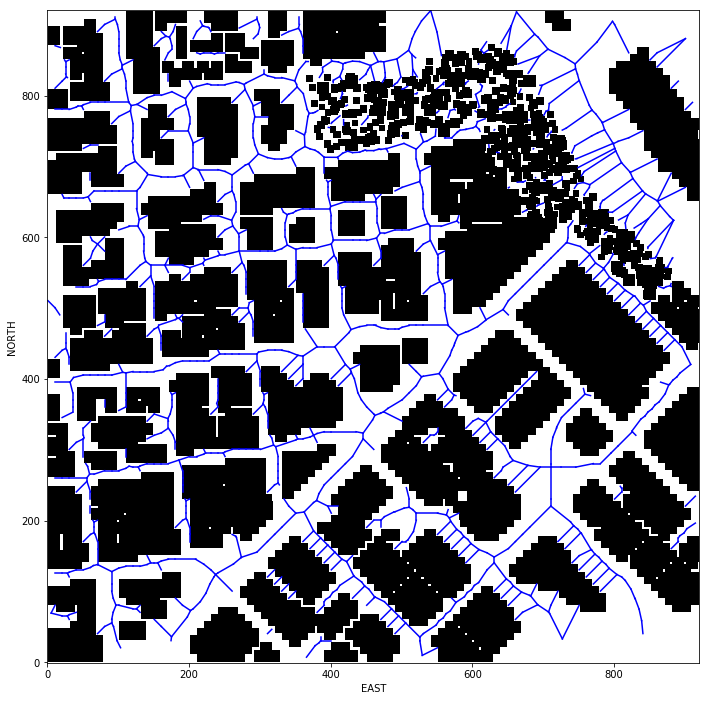

In [72]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys') 

# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()